In [1]:
## Bring in needed mods
import numpy as np, pandas as pd, os, vcfpy
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
## make lables
xl280al = 'XL280'+r'$\alpha$'
xl280_label = 'XL280' +r'$\bf{a}$'

In [3]:
## Set vcf path for the fine mapped progeny 
## and bring in parsed calls
## We have narrowed this script to focus on 
## chromosome 2
vcf_path = '/home/croth/Desktop/QTL/FM_Chr02.vcf'
rdr = vcfpy.Reader.from_path(vcf_path)
recs = [r for r in rdr]
len(recs)

9592

In [4]:
## Gather bam file names, sample names,
## and print how many there are.
sample_names = rdr.header.samples.names
samples = [a.split('_S')[-1].split('_L')[0] 
           for a in sample_names]
len(sample_names),sample_names[:5],samples[:5]

(192,
 ['PMY2349_201904_S1_L001.map.sort.bam',
  'PMY2350_201904_S9_L001.map.sort.bam',
  'PMY2351_201904_S17_L001.map.sort.bam',
  'PMY2352_201904_S25_L001.map.sort.bam',
  'PMY2353_201904_S33_L001.map.sort.bam'],
 ['1', '9', '17', '25', '33'])

In [5]:
## from previous analysis,
## set names of lcnoes and strains with out aneuploidy
fourthirtyone = ['93','94','95','189','190','191']
xl280s = ['96','192']
clones_all = [[5,13,14,15,23,27,32,37],[9,31],[12,19],[57,61,86],[178,183]]
clones = np.concatenate([[str(a) for a in c[1:]] for c in clones_all])
goodguys = ['181', '83', '164', '51', '49', '186', '188', '115', 
            '163', '167', '133', '57', '162', '75', '127', '168', 
            '185', '134', '44', '47', '171', '66', '147', '77', 
            '64', '123', '91', '92', '138', '180', '69', '128', 
            '80', '122', '117', '131', '55', '89', '135', '142', 
            '161', '119', '54', '112', '174', '153', '62', '129', 
            '7', '182', '152', '52', '102', '172', '187', '39', '9', 
            '137', '78', '105', '65', '114', '87', '101', '98', '175', 
            '81', '104', '68', '159', '140', '125', '82', '143', '111', 
            '150', '148', '106', '34', '67', '5', '25', '74', '124', 
            '8', '154', '169', '97', '149', '178', '139', '157', 
            '155', '184', '58', '41', '71', '177', '30', '50', '43']
parents = xl280s + fourthirtyone
segs_ = [s for s in samples if s not in parents + list(clones)]
len(segs_)

172

In [6]:
## Make a dataframe with genotype information
gtdf = pd.DataFrame([[int(s.data['GT']) 
                      for s in rec] 
                     for rec in recs]) 
gtdf.columns = samples
gtdf['Pos'] = [rec.POS for rec in recs]
gtdf['Ref'] = [rec.REF for rec in recs]
gtdf['Alt'] = [rec.ALT for rec in recs]
gtdf['Chrom'] = [rec.CHROM for rec in recs]
gtdf['AF'] = gtdf[segs_].sum(axis=1)/len(segs_)
gtdf['DPmin'] = [np.min([int(s.data['DP']) for s in rec]) for rec in recs]
gtdf['DPmax'] = [np.max([int(s.data['DP']) for s in rec]) for rec in recs]
gtdf['DPmean'] = [np.mean([int(s.data['DP']) for s in rec]) for rec in recs]
#gtdf['ADmin'] = [ np.min([ np.max(s.data['AD'])/(1+np.sum(s.data['AD'])) 
#                          for s in rec]) 
#                 for rec in recs] 

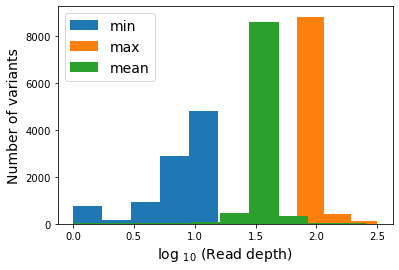

In [7]:
## View the min, manx and mean depth per variants 
## across strains
plt.hist(np.log10(gtdf.DPmin+1),label='min');
plt.hist(np.log10(gtdf.DPmax+1),label='max');
plt.hist(np.log10(gtdf.DPmean+1),label='mean');
plt.legend(fontsize=14);
plt.xlabel('log $_{10}$ (Read depth)',fontsize=14);
plt.ylabel('Number of variants',fontsize=14);

In [8]:
## Filter the vairants
## Take reads with greater than 6 X
filter_ix = (gtdf.DPmin>6)

## Take filtered genetic variants
gv = gtdf[filter_ix].copy()

## sub index for chomosome 2
ch_ix = gv[(gv.Chrom=='Chr02')].index.tolist()

## Take filtered variants
fgv = gv.T[ch_ix].T

## find loci where XL280 isn't zero
xl280_remove = fgv[(fgv[xl280s].sum(axis=1) > 0)
                  ].index.tolist()

## where 431 is zero or inconsistant across samples
fto_remove = fgv[(fgv[fourthirtyone].sum(axis=1)<len(fourthirtyone))
                ].index.tolist()

## make a remove index
ix_remove = np.unique(xl280_remove+fto_remove)

## drop and print shape
fgv.drop(ix_remove,axis=0,inplace=True)
fgv.shape

(5808, 200)

In [9]:
## What is the median distance between variants?
np.mean([np.median(np.diff(a[1]['Pos'])) 
         for a in fgv.groupby('Chrom')])

115.0

In [10]:
## Bring in genotype data for original mapping population
geno_path = '../DATA/GENOTYPE/CDx-ill-SNP-INDEL-df-104-blocked.csv.gz'
f1gv = pd.read_csv(geno_path)
f1gv.shape

(92103, 125)

In [11]:
## Take overlap of variants between the two mapping pops
cindex = []
for c,df in f1gv.groupby('Chrom'):
    
    temp = gtdf[(gtdf.Chrom==c)]
    
    cix = temp[(temp.Pos.isin(df.Pos.tolist()))].index
    cindex.append(cix)
cindex = np.concatenate(cindex)

In [12]:
## How many variants are there?
cindex.shape

(6639,)

In [13]:
## Take those for chromsome 2
## should make no difference
ch2 = fgv[(fgv.Chrom=='Chr02')]

In [14]:
## What is the allele freq at SSK1?
ssk1_af = ch2[(ch2.Pos>=930962) & 
              (ch2.Pos<=935444)].AF.median()
ssk1_af

0.08139534883720931

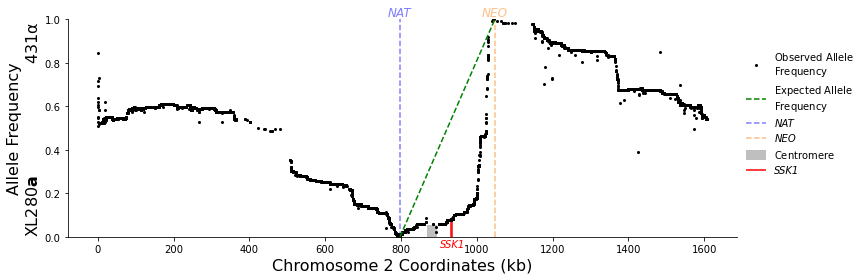

In [15]:
fig,ax = plt.subplots(1,1,figsize=(12,4))
plt.vlines(797055,0,1,color='b',linestyle='--',alpha=0.5,label='NAT');
plt.text(797055,1,color='b',alpha=0.5,s='NAT',va='bottom',ha='center',fontsize=12,style='italic')
plt.vlines(1047346,0,1,color='tab:orange',linestyle='--',alpha=0.5,label='NEO');
plt.text(1047346,1,color='tab:orange',alpha=0.5,s='NEO',
         va='bottom',ha='center',fontsize=12,style='italic')

plt.plot(ch2.Pos,ch2.AF,'k.',label=r'$\rmObserved$' + ' '+ r'$\rmAllele$'+'\n'+r'$\rmFrequency$',ms=4);
plt.ylim(0,1);
plt.vlines(np.mean([855280,905374]),0,0.055,linewidth=10,
           color='grey',label=r'$\rmCentromere$',alpha=0.5);
plt.vlines(np.array([930962,935444]),0,ssk1_af,linestyle='-',
           alpha=0.75,color='r', label='SSK1',linewidth=2)
fig.text(x=0.556,y=0.09,s='SSK1',fontsize=10,color='r',style='italic')
plt.plot(np.array([797055,1047346]),[0,1],color='g',
         linestyle='--',label=r'$\rmExpected$' +' '+ r'$\rmAllele$' +'\n'+r'$\rmFrequency$');
plt.legend(bbox_to_anchor=[1.,0.9],frameon=False,prop=dict(style='italic'))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

l,b = plt.xticks()
plt.xticks(l[1:-1],[int(a) for a in l[1:-1]/1000])

plt.xlabel('Chromosome 2 Coordinates (kb)',fontsize=16)
plt.ylabel('Allele Frequency\n%s                      431\u03B1'%xl280_label,
           fontsize=16)
plt.savefig('../FIGURES/SUPP/PDFs/S17_Fig.pdf',
            bbox_inches='tight',dpi=300);